<a href="https://colab.research.google.com/github/stevejj4/Data-Cleaning/blob/main/SUN_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
from google.colab import auth
import gspread
from google.auth import default

# Authorize Google Colab
auth.authenticate_user()

# Credentials for Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

# Load the Google Sheet
spreadsheet = gc.open('SUN_Dashboard')

# Check if the sheet 'transformed' exists and create it if not
try:
    transformed_sheet = spreadsheet.worksheet('transformed')
except gspread.exceptions.WorksheetNotFound:
    transformed_sheet = spreadsheet.add_worksheet(title='transformed', rows="1000", cols="20")

# Load the original data
worksheet = spreadsheet.sheet1
rows = worksheet.get_all_values()

# Create DataFrame from the sheet data
df = pd.DataFrame(rows)
df.columns = df.iloc[0]  # Set the first row as column names
df = df.iloc[1:]  # Remove the first row


In [44]:
df.shape

(68, 21)

In [45]:
# Reshape the data from wide to long format
value_vars = ['Contribution', 'Compensation', 'Deaths']
months = ['January', 'February', 'March', 'April', 'May']

# Initialize an empty list to store the reshaped data
reshaped_data = []

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    for month in months:
        reshaped_data.append({
            'PAYBILL NO': row['PAYBILL NO'],
            'SUB COUNTY': row['SUB COUNTY'],
            'REGION': row['REGION'],
            'Cluster': row['Cluster'],
            'County': row['County'],
            'Site': row['Site'],
            'Month': month,
            'Contribution': row[f'{month}_Contribution'],
            'Compensation': row[f'{month}_Compensation'],
            'Deaths_per_Month': row[f'{month}_deaths']
        })

# Create a new DataFrame from the reshaped data
reshaped_df = pd.DataFrame(reshaped_data)

# Convert the DataFrame to a list of lists
reshaped_data_list = [reshaped_df.columns.values.tolist()] + reshaped_df.values.tolist()

# Clear the 'transformed' sheet
transformed_sheet.clear()

# Write the reshaped DataFrame to the 'transformed' sheet
transformed_sheet.update('A1', reshaped_data_list)

# Print confirmation
print('Data successfully loaded into the transformed sheet.')


<ipython-input-45-4bb9bf779074>:34: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  transformed_sheet.update('A1', reshaped_data_list)


Data successfully loaded into the transformed sheet.


In [46]:
# Select the sheet named 'transformed'
worksheet = spreadsheet.worksheet('transformed')

# Get all the values from the sheet
rows = worksheet.get_all_values()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(rows)

# Set the first row as the header
df.columns = df.iloc[0]
df = df.drop(0)

In [47]:
#cheking the data type
df.dtypes

0
PAYBILL NO          object
SUB COUNTY          object
REGION              object
Cluster             object
County              object
Site                object
Month               object
Contribution        object
Compensation        object
Deaths_per_Month    object
dtype: object

In [48]:
# Check if there maybe any missing data
df.isnull().sum()

0
PAYBILL NO          0
SUB COUNTY          0
REGION              0
Cluster             0
County              0
Site                0
Month               0
Contribution        0
Compensation        0
Deaths_per_Month    0
dtype: int64

In [51]:
# Remove commas from the numeric columns and convert to float
df['Contribution'] = df['Contribution'].astype(str).str.replace(',', '').astype(float)
df['Compensation'] = df['Compensation'].astype(str).str.replace(',', '').astype(float)
df['Deaths_per_Month'] = df['Deaths_per_Month'].astype(str).str.replace(',', '').astype(float)

# Inspect the cleaned data
df.head()

,PAYBILL NO,SUB COUNTY,REGION,Cluster,County,Site,Month,Contribution,Compensation,Deaths_per_Month
1,4068299,KIBERA,Nairobi,1,Nairobi,Sub County,January,976470.0,610000.0,13.0
2,4068299,KIBERA,Nairobi,1,Nairobi,Sub County,February,755400.0,660000.0,14.0
3,4068299,KIBERA,Nairobi,1,Nairobi,Sub County,March,742030.0,740000.0,16.0
4,4068299,KIBERA,Nairobi,1,Nairobi,Sub County,April,717701.0,940000.0,20.0
5,4068299,KIBERA,Nairobi,1,Nairobi,Sub County,May,851222.0,250000.0,5.0


## Explanatory data analysis(EDA)
The graphical exploration/ representation of data (1977, John Turkey). From this we are able to form hypothesess for our data for further analyses or study
‘Exploratory data analysis’ is an attitude, a state of flexibility, a willingness to look for those things that we believe are not there, as well as those we believe to be there.”

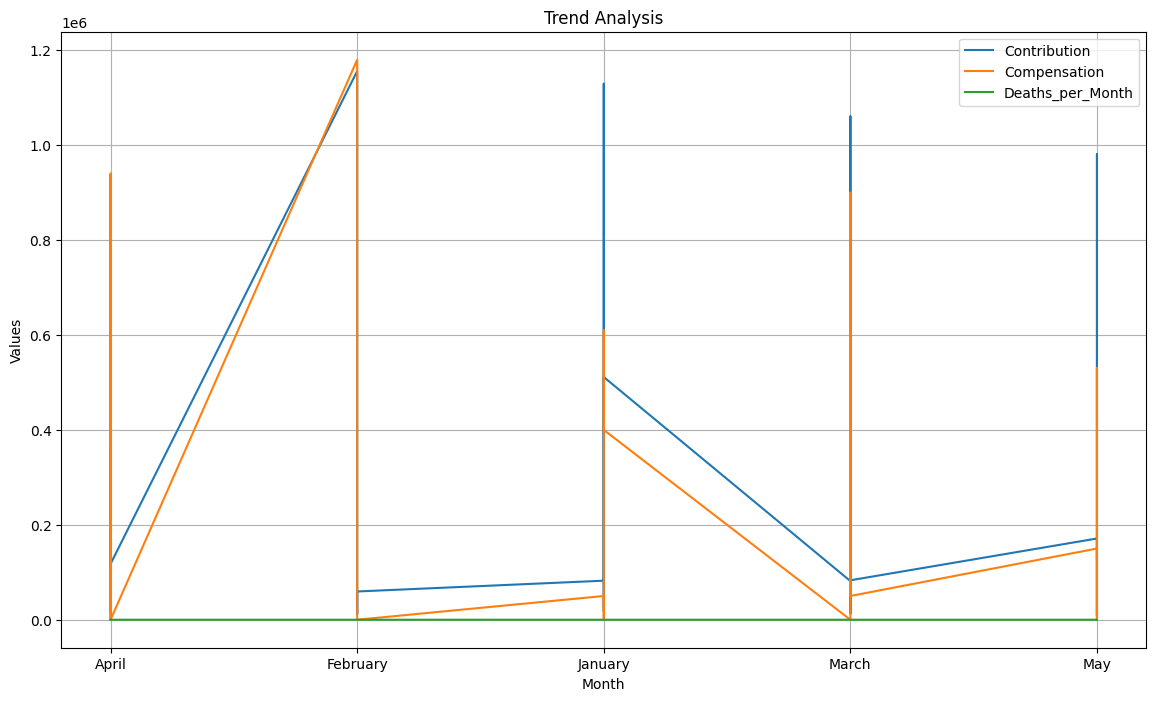

In [53]:
# “Graphs force us to note the unexpected; nothing could be more important.”
#Lets start by analyzing the monthly trends for contributions, compensation amounts and the number of deaths
#Converting the Month column to a categorical type with a proper order
# Assuming transformed_data is your DataFrame

import pandas as pd
import matplotlib.pyplot as plt



# Sort the DataFrame by Month
df = df.sort_values(by='Month')

# Plotting trends
plt.figure(figsize=(14, 8))
for col in ['Contribution', 'Compensation', 'Deaths_per_Month']:
    plt.plot(df['Month'], df[col], label=col)
plt.xlabel('Month')
plt.ylabel('Values')
plt.title('Trend Analysis')
plt.legend()
plt.grid(True)
plt.show()


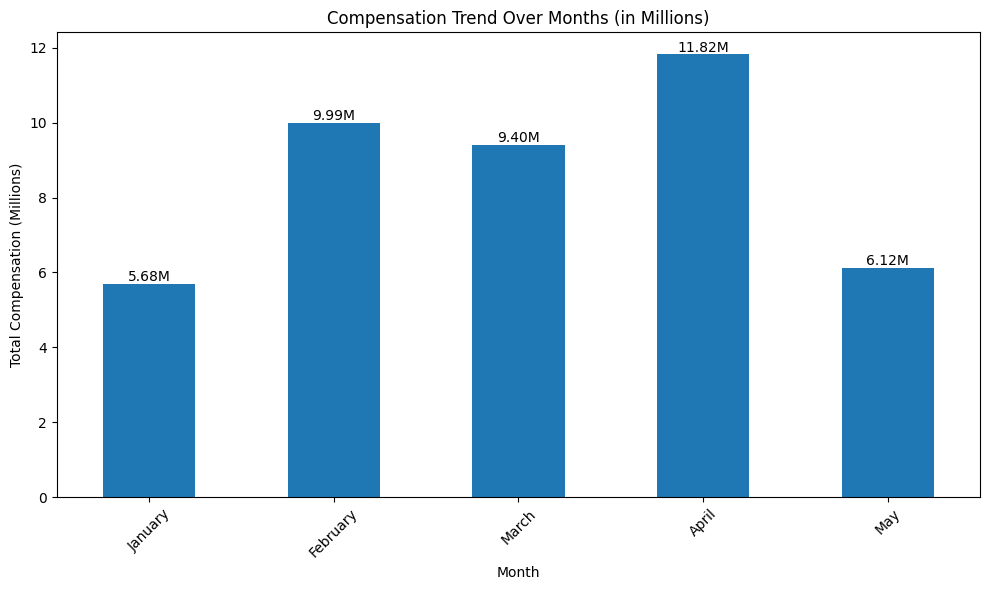

In [60]:
import matplotlib.pyplot as plt

# Group the data by month and calculate the total compensation for each month
monthly_compensation = df.groupby('Month')['Compensation'].sum()

# Ensure months are in the correct order (January to May)
month_order = ['January', 'February', 'March', 'April', 'May']
monthly_compensation = monthly_compensation.reindex(month_order)

# Convert compensation to millions
monthly_compensation_millions = monthly_compensation / 1_000_000

# Create a bar chart to visualize the trend
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = monthly_compensation_millions.plot(kind='bar')
plt.title('Compensation Trend Over Months (in Millions)')
plt.xlabel('Month')
plt.ylabel('Total Compensation (Millions)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add labels above each bar with 'M' to indicate millions
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}M', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()